In [1]:
import requests, os, zipfile
import glob
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib as mpl
# Path to the events archive
dataset_zip = '/tmp/events.zip'

# Path to the extracted events
dataset_dir = '/tmp/events/'

# Path to the dataset file
dataset_pkl = '/tmp/dataset.zip'

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download the dataset
download_file_from_google_drive('1ZPgbhToHLXfLg2IPl0QkxgP6I1TI-KdU', dataset_zip)

# Unzip the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [3]:
# The dataframe of the events
events = pd.DataFrame()

# Get paths to the event files
pkl_paths = glob.glob(dataset_dir + '*.pkl')

# Concatenate the events
for pkl_path in pkl_paths:
  # Unpickle the event file
  pkl_file = open(pkl_path, 'rb')
  event = pk.load(pkl_file)

  # Create a dataframe for the event
  event = pd.DataFrame({'image': event[0], 'label': event[1]})

  # Concatenate the event
  events = pd.concat([events, event], axis=0)

# Save the dataset
events.to_pickle(dataset_pkl)

In [4]:
df = events.copy()
df['diag'] = events['image'].apply(np.diag)

In [5]:
df = df.drop(['image'], axis=1)
df=df.reindex(columns=['diag','label'])
df.head()

,diag,label
0,"[2.0, 3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",2212
1,"[3.0, 3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, ...",2212
2,"[4.0, 3.0, 3.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",321
3,"[3.0, 2.0, 4.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",211
4,"[3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, ...",321


In [6]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])
df

,diag,label
0,"[2.0, 3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",4
1,"[3.0, 3.0, 2.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, ...",4
2,"[4.0, 3.0, 3.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",3
3,"[3.0, 2.0, 4.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",2
4,"[3.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, ...",3
...,...,...
2729,"[3.0, 2.0, 1.0, 2.0, 2.0, 0.0, 1.0, 1.0, 0.0, ...",2
2730,"[5.0, 1.0, 2.0, 1.0, 0.0, 1.0, 2.0, 0.0, 1.0, ...",2
2731,"[3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, ...",2
2732,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [7]:
X_train, X_rest, y_train, y_rest = train_test_split(np.stack(df['diag'].to_numpy()), df['label'].to_numpy(), test_size=.3)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=.33)
df['label'].unique()


array([4, 3, 2, 0, 1])

In [8]:
clf_balanced = RandomForestClassifier(class_weight='balanced')
clf_balanced.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
y_pred = clf_balanced.predict(X_test)
y_pred_decoded = encoder.inverse_transform(y_pred)
y_test_decoded = encoder.inverse_transform(y_test)

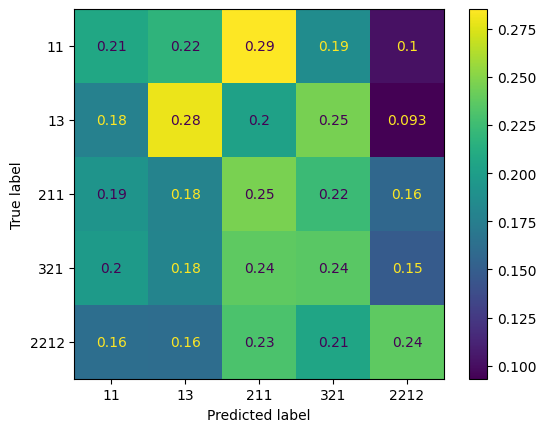

In [14]:
 # Build a confusion matrix for the model
mpl.rcParams.update(mpl.rcParamsDefault)
cm = confusion_matrix(np.array(y_test_decoded, dtype=str), np.array(y_pred_decoded, dtype=str), np.array(np.unique(y_test_decoded), dtype=str), normalize='true')
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(np.unique(y_test_decoded)))
cmd.plot(include_values=True,
          cmap='viridis',
          ax=None,
          xticks_rotation='horizontal')
plt.savefig('/tmp/Rf_balanced', bbox_inches='tight')
plt.show()


In [13]:
print(classification_report(np.array(y_test_decoded, dtype=str), np.array(y_pred_decoded, dtype=str)))

              precision    recall  f1-score   support

          11       0.00      0.21      0.01       284
          13       0.00      0.28      0.00       118
         211       0.78      0.25      0.37     89543
        2212       0.14      0.24      0.18     11137
         321       0.14      0.24      0.18     15390

    accuracy                           0.24    116472
   macro avg       0.21      0.24      0.15    116472
weighted avg       0.63      0.24      0.33    116472



In [15]:
clf_unbalanced = RandomForestClassifier()
clf_unbalanced.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
y_pred = clf_unbalanced.predict(X_test)
y_pred_decoded = encoder.inverse_transform(y_pred)

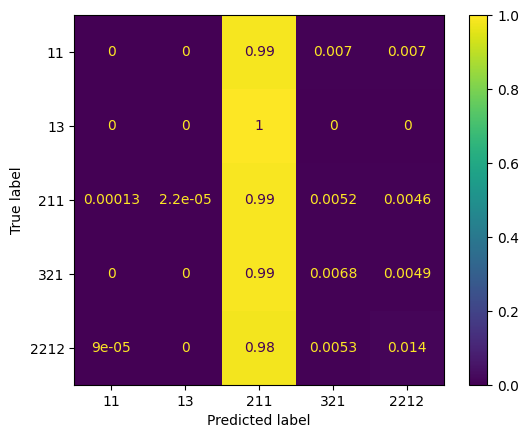

In [19]:
mpl.rcParams.update(mpl.rcParamsDefault)
cm = confusion_matrix(np.array(y_test_decoded, dtype=str), np.array(y_pred_decoded, dtype=str), np.array(np.unique(y_test_decoded), dtype=str), normalize='true')
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(np.unique(y_test_decoded)))
cmd.plot(include_values=True,
          cmap='viridis',
          ax=None,
          xticks_rotation='horizontal')
plt.savefig('/tmp/Rf_unbalanced', bbox_inches='tight')
plt.show()

In [20]:
print(classification_report(np.array(y_test_decoded, dtype=str), np.array(y_pred_decoded, dtype=str)))


              precision    recall  f1-score   support

          11       0.00      0.00      0.00       284
          13       0.00      0.00      0.00       118
         211       0.77      0.99      0.87     89543
        2212       0.24      0.01      0.03     11137
         321       0.17      0.01      0.01     15390

    accuracy                           0.76    116472
   macro avg       0.23      0.20      0.18    116472
weighted avg       0.64      0.76      0.67    116472

